In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sopt.optimizers.tensorflow2 import LMA, NonLinearConjugateGradient
import scipy.optimize as spopt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
z_true = np.random.randn(3,10).astype('float32')

random_mat = np.random.randn(3,3)
random_symmetric_mat = random_mat + random_mat.T
evals, evecs = np.linalg.eig(random_symmetric_mat)
affine_transform = evecs

y_true = affine_transform @ z_true
y_true_flat = y_true.flatten()

In [4]:
def y_pred(z_flat, affine_transform):
    z_arr = tf.reshape(z_flat, (3, -1))
    return tf.reshape(affine_transform @ z_arr, [-1])

def loss_fn(y):
    return 0.5 * tf.reduce_sum((y - y_true_flat)**2)

In [5]:
z_guess = np.random.randn(30).astype('float32')

In [30]:
v1 = tf.Variable(z_guess, dtype=tf.float32)
v2 = tf.Variable(z_guess, dtype=tf.float32)
v3 = tf.Variable(z_guess, dtype=tf.float32)

y_true_t = tf.constant(y_true, dtype='float32')
affine_transform_t = tf.constant(affine_transform, dtype='float32')

preds_fn = lambda v: y_pred(v, affine_transform_t)
                            
lma1 = LMA(input_var=v1, predictions_fn=preds_fn,
           loss_fn=loss_fn, name='opt1', min_cg_tol=0.1,
           assert_tolerances=False)
lma2 = LMA(input_var=v2, predictions_fn=preds_fn,
           loss_fn=loss_fn, name='opt2', min_cg_tol=0.1,  
           diag_hessian_fn=lambda v: 1.0, 
           assert_tolerances=False)
cg1 = NonLinearConjugateGradient(input_var=v3, 
                                  objective_fn=lambda v: loss_fn(preds_fn(v)),
                                  name='opt3')

In [31]:
lm_losses1 = []
lm_losses2 = []
cg_losses = []
for i in range(10):
    _, loss1 = lma1.minimize(), lma1._loss_new.numpy()
    _, loss2 = lma2.minimize(), lma2._loss_new.numpy()
    loss3 = cg1.minimize().numpy()
    print(i, loss1, loss2, loss3)
    lm_losses1.append(loss1)
    lm_losses2.append(loss2)
    cg_losses.append(loss3)

0 3.816161e-07 3.816161e-07 34.79165
1 2.1427304e-14 2.1427304e-14 21.488962
2 0.0 0.0 7.02619
3 0.0 0.0 0.14492956
4 0.0 0.0 0.073627576
5 0.0 0.0 0.037404492
6 0.0 0.0 0.01900234
7 0.0 0.0 0.009653628
8 0.0 0.0 0.004904267
9 0.0 0.0 0.0024914856


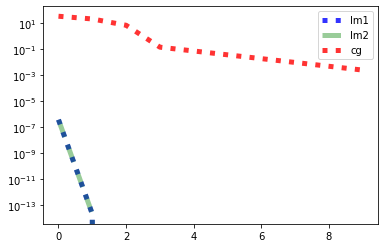

In [32]:
plt.plot(lm_losses1, color='blue', ls=':', linewidth=5.0, alpha=0.8, label='lm1')
plt.plot(lm_losses2, color='green', ls='--', linewidth=5.0, alpha=0.4, label='lm2')
plt.plot(cg_losses, color='red', ls=':', linewidth=5.0, alpha=0.8, label='cg')
plt.yscale('log')
plt.legend(loc='best')
plt.show()